# Imports and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score



2024-02-03 15:15:54.930679: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 15:15:54.975972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 15:15:54.976006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 15:15:54.977427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 15:15:54.984969: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import torchvision
import engine
import engine_boosted
import engine_boosted_multi
import helper_functions

In [3]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [4]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [5]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [6]:
kernel = {
    'ATF2': [10] ,
    'ATF3' : [10] ,
    'CEBPB' : [10] ,
    'CREB1' : [8] ,
    'CTCF' : [15] ,
    'E2F4' : [13] ,
    'EGR1' : [10] ,
    'EFL1' : [9] ,
    'ELK1' : [9] ,
    'FOS' : [8] ,
    'FOXA1' : [8] ,
    'GABPA' : [10] ,
    'JUN' : [14] ,
    'JUND' : [11] ,
    'MAFK' : [10] ,
    'MAX' : [6] ,
    'MAZ' : [8] ,
    'MXI1' : [6] ,
    'MYC' : [8] ,
    'NRF1' : [11] ,
    'RELA' : [10] ,
    'REST' : [20] ,
    'RFX5' : [14] ,
    'SP1' : [9] ,
    'SRF' : [16] ,
    'TCF7L2' : [9] ,
    'TCF12' : [7] ,
    'TEAD4' : [8] ,
    'USF1' : [10] ,
    'USF2' : [10] ,
    'YY1' : [12] ,
    'ZBTB33' : [10] ,
    'ZNF274' : [12]
}

In [7]:
tf_class = {
    'ATF2': 0,
    'ATF3': 1,
    'CEBPB': 2,
    'CREB1': 3,
    'CTCF': 4,
    'E2F4': 5,
    'EGR1': 6,
    'EFL1': 7,
    'ELK1': 8,
    'FOS': 9,
    'FOXA1': 10,
    'GABPA': 11,
    'JUN': 12,
    'JUND': 13,
    'MAFK': 14,
    'MAX': 15,
    'MAZ': 16,
    'MXI1': 17,
    'MYC': 18,
    'NRF1': 19,
    'RELA': 20,
    'REST': 21,
    'RFX5': 22,
    'SP1': 23,
    'SRF': 24,
    'TCF7L2': 25,
    'TCF12': 26,
    'TEAD4': 27,
    'USF1': 28,
    'USF2': 29,
    'YY1': 30,
    'ZBTB33': 31,
    'ZNF274': 32
}

# Set up device agnostic code

In [8]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
import pandas as pd

# Read the list of TFs from the file
tf_list_path = '/mnt/raid1/thalassini/home/Downloads/target_names_6.txt'
with open(tf_list_path, 'r') as file:
    tf_list = file.read().splitlines()

# Define the directory where the CSV files for each TF are located
base_directory = '/mnt/raid1/thalassini/home/filtered_fimo_chrom_200/'

# Combine data for each TF and write to a single CSV file
for tf in tf_list:
    file_path = f'{base_directory}{tf.upper()}/datasets/data.csv'
    
    try:
        df = pd.read_csv(file_path)
        
        # Add a column to identify the TF
        df['TF'] = tf
        
        # Append data to the master DataFrame or create it if it doesn't exist
        if 'master_df' in locals():
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            master_df = df
    except FileNotFoundError:
        print(f"File not found for TF: {tf}")

# Save the combined DataFrame to a new CSV file
output_csv_path = '/mnt/raid1/thalassini/home/tf_data/combined_6_data.csv'
master_df.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")


File not found for TF: RCOR1
Combined data saved to /mnt/raid1/thalassini/home/tf_data/combined_6_data.csv


In [10]:
master_df

,chrom,data,class,TF
0,chr1,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,ATF2
1,chr1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,ATF2
2,chr6,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,ATF2
3,chr4,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,ATF2
4,chr11,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,ATF2
...,...,...,...,...
1204211,chr5,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,ZNF274
1204212,chr19,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,ZNF274
1204213,chr19,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,ZNF274
1204214,chr1,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,ZNF274


In [11]:
print("Unique values in 'TF' column before mapping:", master_df['TF'].unique())


Unique values in 'TF' column before mapping: ['ATF2' 'ATF3' 'CEBPB' 'CREB1' 'CTCF' 'E2F4' 'EGR1' 'ELF1' 'ELK1' 'FOS'
 'FOXA1' 'GABPA' 'JUN' 'JUND' 'MAFK' 'MAX' 'MAZ' 'MXI1' 'MYC' 'NRF1'
 'RELA' 'REST' 'RFX5' 'SP1' 'SRF' 'TCF12' 'TCF7L2' 'TEAD4' 'USF1' 'USF2'
 'YY1' 'ZBTB33' 'ZNF274']


In [12]:

# Apply the mapping to the 'TF' column
master_df['TF'] = master_df['TF'].map(tf_class)

# Drop rows with NaN values in the 'TF' column
master_df = master_df.dropna(subset=['TF'])

# Convert the 'TF' column to integers
master_df['TF'] = master_df['TF'].astype(int)
master_df

/tmp/ipykernel_604784/3393081513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['TF'] = master_df['TF'].astype(int)


,chrom,data,class,TF
0,chr1,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,0
1,chr1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,0
2,chr6,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,0
3,chr4,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,0
4,chr11,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,0
...,...,...,...,...
1204211,chr5,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,32
1204212,chr19,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,32
1204213,chr19,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,32
1204214,chr1,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,32


# Sequence length inspection and normalization

Max length:200, Min length: 200


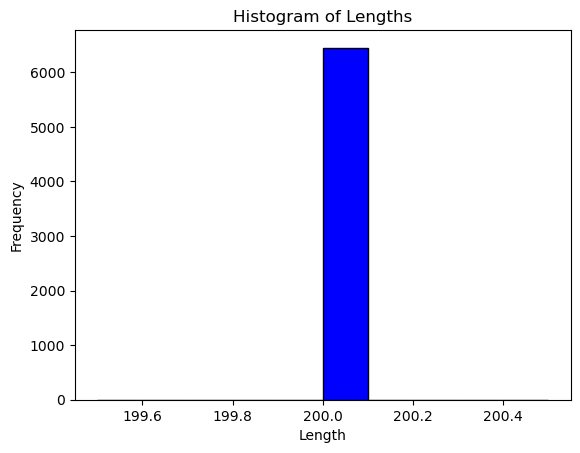

In [13]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [15]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Define X,y variables

In [16]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [17]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [18]:
X.shape

torch.Size([6450, 200, 4])

In [19]:
#y=np.array(df['TF'])
y=np.array(df['class'])

y[:3]

array([1, 1, 1])

In [20]:
y = torch.from_numpy(y).type(torch.float)

# Split the data in train, val and test set

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit



# Split the data into a stratified hold-out validation set and the rest
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_val_index, test_index in stratified_splitter.split(X, y):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))
print(len(X_test), len(y_test))


# (X_train, X_val, y_train, y_val) for training, validation
# X_test, y_test for the final hold-out validation.

#X_train, X_val, X_test = torch.from_numpy(X_train).type(torch.float),torch.from_numpy(X_val).type(torch.float), torch.from_numpy(X_test).type(torch.float)



4128 4128 1032 1032
1290 1290


# Create datasets and Dataloaders

In [22]:
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)


# Expand the dimensions of y to make it 2-dimensional
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1,1)
y_val = y_val.view(-1,1)
# Concatenate the complement of y to create a 2-dimensional tensor

y_train_one_hot = torch.cat([1 - y_train, y_train], dim=1).float()
y_test_one_hot = torch.cat([1 - y_test, y_test], dim=1).float()
y_val_one_hot = torch.cat([1 - y_val, y_val], dim=1).float()


# Move tensors to the same device
X_train,y_train_one_hot, y_train = X_train.to(device), y_train_one_hot.to(device), y_train.to(device)
X_val, y_val_one_hot, y_val = X_val.to(device), y_val_one_hot.to(device), y_val.to(device)
X_test, y_test_one_hot, y_test = X_test.to(device),  y_test_one_hot.to(device), y_test.to(device)


print(X_train.size(0),  y_train.size(0))

# Create datasets
train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)
val_dataset = TensorDataset(X_val, y_val_one_hot, y_val)
test_dataset = TensorDataset(X_test, y_test_one_hot, y_test)



4128 4128


In [23]:

batch_size=64
torch.manual_seed(42)

# Convert to PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [24]:
class Conv_v0(torch.nn.Module):

    def __init__(self):
        super(Conv_v0, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels=5, kernel_size=17)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        
        self.dropout = torch.nn.Dropout(p=0.25) 
        #in_features = 108 for 200kb, 588 for 1kb, 1188 for 2kb
        self.fc =  torch.nn.LazyLinear(out_features=2)
        #self.sigmoid = torch.nn.Sigmoid() will not be used since its intergraded in BCEWithLogitsLoss()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
        x = self.fc(x)
        #x = self.softmax(x)
        #x = self.sigmoid(x)
        return x


# Computing class weights

In [25]:
"""
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Assuming we have defined dataset
# train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)

# Extract the labels from the dataset
_, _, y_train = zip(*train_dataset)

# Count occurrences of each class
class_0_count = sum(1 for label in y_train if label == 0)
class_1_count = sum(1 for label in y_train if label == 1)

# Total length of y_train
total_samples = len(y_train)

# Calculate class weights
weights = [total_samples / class_0_count, total_samples / class_1_count]

# Print the list of class weights
print("Class Weights List:", weights)


"""

'\nfrom torch.utils.data import DataLoader, TensorDataset\nfrom sklearn.utils.class_weight import compute_class_weight\n\n# Assuming we have defined dataset\n# train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)\n\n# Extract the labels from the dataset\n_, _, y_train = zip(*train_dataset)\n\n# Count occurrences of each class\nclass_0_count = sum(1 for label in y_train if label == 0)\nclass_1_count = sum(1 for label in y_train if label == 1)\n\n# Total length of y_train\ntotal_samples = len(y_train)\n\n# Calculate class weights\nweights = [total_samples / class_0_count, total_samples / class_1_count]\n\n# Print the list of class weights\nprint("Class Weights List:", weights)\n\n\n'

# Set up loss function and optimizer

In [26]:
from torch.optim import lr_scheduler
#weights = torch.tensor(weights).to(device)
#print(weights)

In [27]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v0()

#loss_fn = nn.BCEWithLogitsLoss(weight=weights)
loss_fn = nn.BCEWithLogitsLoss()

# Define oprimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define exponetntial lr with lr_scheduler
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

/mnt/raid1/thalassini/home/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.1138,  0.0535],
        [-0.0691,  0.2093],
        [-0.2030,  0.0951],
        [-0.0292,  0.1903],
        [-0.2808,  0.2974]], grad_fn=<SliceBackward0>)

In [29]:
# Check number of classes in the model
num_classes_model = model.fc.out_features  # Adjust accordingly


In [30]:
num_classes_model

2

In [31]:
results, _ = engine_boosted.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=val_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=800,
                                                  device=device)


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6932 | train_bal_acc: 0.5388 | train_mcc: 0.0780 | train_auroc: 0.5283  |  valid_loss: 0.6882 | valid_bal_acc: 0.5523 | valid_mcc: 0.1117  |  valid_auroc: 0.5949
Epoch: 2 | train_loss: 0.6839 | train_bal_acc: 0.6013 | train_mcc: 0.2106 | train_auroc: 0.6200  |  valid_loss: 0.6757 | valid_bal_acc: 0.7168 | valid_mcc: 0.4328  |  valid_auroc: 0.7407
Epoch: 3 | train_loss: 0.6706 | train_bal_acc: 0.6472 | train_mcc: 0.3170 | train_auroc: 0.7183  |  valid_loss: 0.6579 | valid_bal_acc: 0.7605 | valid_mcc: 0.5297  |  valid_auroc: 0.8243
Epoch: 4 | train_loss: 0.6525 | train_bal_acc: 0.6942 | train_mcc: 0.4034 | train_auroc: 0.7750  |  valid_loss: 0.6369 | valid_bal_acc: 0.7846 | valid_mcc: 0.5672  |  valid_auroc: 0.8477
Epoch: 5 | train_loss: 0.6297 | train_bal_acc: 0.7282 | train_mcc: 0.4635 | train_auroc: 0.8069  |  valid_loss: 0.6075 | valid_bal_acc: 0.8099 | valid_mcc: 0.6222  |  valid_auroc: 0.8599
Epoch: 6 | train_loss: 0.6078 | train_bal_acc: 0.7515 | train_mcc

Epoch: 45 | train_loss: 0.4127 | train_bal_acc: 0.8162 | train_mcc: 0.6346 | train_auroc: 0.8945  |  valid_loss: 0.3819 | valid_bal_acc: 0.8380 | valid_mcc: 0.6787  |  valid_auroc: 0.9143
Epoch: 46 | train_loss: 0.4136 | train_bal_acc: 0.8178 | train_mcc: 0.6359 | train_auroc: 0.8949  |  valid_loss: 0.3827 | valid_bal_acc: 0.8391 | valid_mcc: 0.6802  |  valid_auroc: 0.9160
Epoch: 47 | train_loss: 0.4122 | train_bal_acc: 0.8168 | train_mcc: 0.6357 | train_auroc: 0.8940  |  valid_loss: 0.3843 | valid_bal_acc: 0.8284 | valid_mcc: 0.6674  |  valid_auroc: 0.9096
Epoch: 48 | train_loss: 0.4072 | train_bal_acc: 0.8220 | train_mcc: 0.6435 | train_auroc: 0.8996  |  valid_loss: 0.3736 | valid_bal_acc: 0.8443 | valid_mcc: 0.6888  |  valid_auroc: 0.9203
Epoch: 49 | train_loss: 0.4080 | train_bal_acc: 0.8186 | train_mcc: 0.6362 | train_auroc: 0.8982  |  valid_loss: 0.3800 | valid_bal_acc: 0.8341 | valid_mcc: 0.6749  |  valid_auroc: 0.9113
Epoch: 50 | train_loss: 0.4080 | train_bal_acc: 0.8181 | tra

Epoch: 89 | train_loss: 0.3749 | train_bal_acc: 0.8346 | train_mcc: 0.6710 | train_auroc: 0.9113  |  valid_loss: 0.3470 | valid_bal_acc: 0.8500 | valid_mcc: 0.6898  |  valid_auroc: 0.9299
Epoch: 90 | train_loss: 0.3652 | train_bal_acc: 0.8425 | train_mcc: 0.6849 | train_auroc: 0.9192  |  valid_loss: 0.3368 | valid_bal_acc: 0.8436 | valid_mcc: 0.6915  |  valid_auroc: 0.9350
Epoch: 91 | train_loss: 0.3691 | train_bal_acc: 0.8391 | train_mcc: 0.6797 | train_auroc: 0.9157  |  valid_loss: 0.3397 | valid_bal_acc: 0.8519 | valid_mcc: 0.7057  |  valid_auroc: 0.9355
Epoch: 92 | train_loss: 0.3621 | train_bal_acc: 0.8400 | train_mcc: 0.6813 | train_auroc: 0.9208  |  valid_loss: 0.3474 | valid_bal_acc: 0.8321 | valid_mcc: 0.6695  |  valid_auroc: 0.9295
Epoch: 93 | train_loss: 0.3607 | train_bal_acc: 0.8419 | train_mcc: 0.6863 | train_auroc: 0.9204  |  valid_loss: 0.3363 | valid_bal_acc: 0.8528 | valid_mcc: 0.7077  |  valid_auroc: 0.9315
Epoch: 94 | train_loss: 0.3651 | train_bal_acc: 0.8415 | tra

Epoch: 133 | train_loss: 0.3372 | train_bal_acc: 0.8531 | train_mcc: 0.7079 | train_auroc: 0.9310  |  valid_loss: 0.3118 | valid_bal_acc: 0.8679 | valid_mcc: 0.7342  |  valid_auroc: 0.9429
Epoch: 134 | train_loss: 0.3366 | train_bal_acc: 0.8565 | train_mcc: 0.7147 | train_auroc: 0.9310  |  valid_loss: 0.3142 | valid_bal_acc: 0.8631 | valid_mcc: 0.7280  |  valid_auroc: 0.9425
Epoch: 135 | train_loss: 0.3318 | train_bal_acc: 0.8576 | train_mcc: 0.7157 | train_auroc: 0.9349  |  valid_loss: 0.3128 | valid_bal_acc: 0.8652 | valid_mcc: 0.7340  |  valid_auroc: 0.9411
Epoch: 136 | train_loss: 0.3350 | train_bal_acc: 0.8554 | train_mcc: 0.7114 | train_auroc: 0.9321  |  valid_loss: 0.3116 | valid_bal_acc: 0.8640 | valid_mcc: 0.7284  |  valid_auroc: 0.9425
Epoch: 137 | train_loss: 0.3359 | train_bal_acc: 0.8519 | train_mcc: 0.7038 | train_auroc: 0.9320  |  valid_loss: 0.3189 | valid_bal_acc: 0.8579 | valid_mcc: 0.7173  |  valid_auroc: 0.9400
Epoch: 138 | train_loss: 0.3407 | train_bal_acc: 0.8551

Epoch: 177 | train_loss: 0.3294 | train_bal_acc: 0.8566 | train_mcc: 0.7151 | train_auroc: 0.9341  |  valid_loss: 0.2954 | valid_bal_acc: 0.8771 | valid_mcc: 0.7527  |  valid_auroc: 0.9462
Epoch: 178 | train_loss: 0.3208 | train_bal_acc: 0.8622 | train_mcc: 0.7245 | train_auroc: 0.9377  |  valid_loss: 0.3014 | valid_bal_acc: 0.8730 | valid_mcc: 0.7471  |  valid_auroc: 0.9476
Epoch: 179 | train_loss: 0.3195 | train_bal_acc: 0.8629 | train_mcc: 0.7262 | train_auroc: 0.9374  |  valid_loss: 0.3009 | valid_bal_acc: 0.8789 | valid_mcc: 0.7575  |  valid_auroc: 0.9516
Epoch: 180 | train_loss: 0.3175 | train_bal_acc: 0.8664 | train_mcc: 0.7324 | train_auroc: 0.9394  |  valid_loss: 0.3015 | valid_bal_acc: 0.8668 | valid_mcc: 0.7392  |  valid_auroc: 0.9432
Epoch: 181 | train_loss: 0.3209 | train_bal_acc: 0.8657 | train_mcc: 0.7320 | train_auroc: 0.9387  |  valid_loss: 0.2942 | valid_bal_acc: 0.8763 | valid_mcc: 0.7510  |  valid_auroc: 0.9470
Epoch: 182 | train_loss: 0.3248 | train_bal_acc: 0.8588

Epoch: 221 | train_loss: 0.3077 | train_bal_acc: 0.8685 | train_mcc: 0.7371 | train_auroc: 0.9429  |  valid_loss: 0.2952 | valid_bal_acc: 0.8767 | valid_mcc: 0.7472  |  valid_auroc: 0.9503
Epoch: 222 | train_loss: 0.3091 | train_bal_acc: 0.8692 | train_mcc: 0.7384 | train_auroc: 0.9420  |  valid_loss: 0.2913 | valid_bal_acc: 0.8818 | valid_mcc: 0.7585  |  valid_auroc: 0.9522
Epoch: 223 | train_loss: 0.3087 | train_bal_acc: 0.8683 | train_mcc: 0.7381 | train_auroc: 0.9432  |  valid_loss: 0.3191 | valid_bal_acc: 0.8586 | valid_mcc: 0.7217  |  valid_auroc: 0.9281
Epoch: 224 | train_loss: 0.3082 | train_bal_acc: 0.8705 | train_mcc: 0.7413 | train_auroc: 0.9427  |  valid_loss: 0.2923 | valid_bal_acc: 0.8718 | valid_mcc: 0.7498  |  valid_auroc: 0.9478
Epoch: 225 | train_loss: 0.3099 | train_bal_acc: 0.8678 | train_mcc: 0.7346 | train_auroc: 0.9431  |  valid_loss: 0.2835 | valid_bal_acc: 0.8803 | valid_mcc: 0.7596  |  valid_auroc: 0.9504
Epoch: 226 | train_loss: 0.3076 | train_bal_acc: 0.8728

Epoch: 265 | train_loss: 0.2962 | train_bal_acc: 0.8725 | train_mcc: 0.7448 | train_auroc: 0.9453  |  valid_loss: 0.2931 | valid_bal_acc: 0.8675 | valid_mcc: 0.7351  |  valid_auroc: 0.9509
Epoch: 266 | train_loss: 0.2987 | train_bal_acc: 0.8725 | train_mcc: 0.7447 | train_auroc: 0.9448  |  valid_loss: 0.2858 | valid_bal_acc: 0.8760 | valid_mcc: 0.7519  |  valid_auroc: 0.9569
Epoch: 267 | train_loss: 0.2909 | train_bal_acc: 0.8747 | train_mcc: 0.7500 | train_auroc: 0.9487  |  valid_loss: 0.2976 | valid_bal_acc: 0.8689 | valid_mcc: 0.7396  |  valid_auroc: 0.9564
Epoch: 268 | train_loss: 0.3010 | train_bal_acc: 0.8691 | train_mcc: 0.7400 | train_auroc: 0.9450  |  valid_loss: 0.2789 | valid_bal_acc: 0.8772 | valid_mcc: 0.7540  |  valid_auroc: 0.9514
Epoch: 269 | train_loss: 0.2916 | train_bal_acc: 0.8743 | train_mcc: 0.7490 | train_auroc: 0.9500  |  valid_loss: 0.2861 | valid_bal_acc: 0.8773 | valid_mcc: 0.7582  |  valid_auroc: 0.9463
Epoch: 270 | train_loss: 0.2991 | train_bal_acc: 0.8725

Epoch: 309 | train_loss: 0.2873 | train_bal_acc: 0.8762 | train_mcc: 0.7535 | train_auroc: 0.9504  |  valid_loss: 0.2745 | valid_bal_acc: 0.8862 | valid_mcc: 0.7730  |  valid_auroc: 0.9531
Epoch: 310 | train_loss: 0.2818 | train_bal_acc: 0.8816 | train_mcc: 0.7633 | train_auroc: 0.9535  |  valid_loss: 0.2777 | valid_bal_acc: 0.8821 | valid_mcc: 0.7648  |  valid_auroc: 0.9533
Epoch: 311 | train_loss: 0.2819 | train_bal_acc: 0.8830 | train_mcc: 0.7644 | train_auroc: 0.9514  |  valid_loss: 0.2735 | valid_bal_acc: 0.8853 | valid_mcc: 0.7705  |  valid_auroc: 0.9533
Epoch: 312 | train_loss: 0.2828 | train_bal_acc: 0.8823 | train_mcc: 0.7643 | train_auroc: 0.9515  |  valid_loss: 0.2825 | valid_bal_acc: 0.8837 | valid_mcc: 0.7562  |  valid_auroc: 0.9551
Epoch: 313 | train_loss: 0.2834 | train_bal_acc: 0.8806 | train_mcc: 0.7604 | train_auroc: 0.9505  |  valid_loss: 0.2737 | valid_bal_acc: 0.8758 | valid_mcc: 0.7566  |  valid_auroc: 0.9536
Epoch: 314 | train_loss: 0.2815 | train_bal_acc: 0.8847

Epoch: 353 | train_loss: 0.2781 | train_bal_acc: 0.8840 | train_mcc: 0.7678 | train_auroc: 0.9526  |  valid_loss: 0.2673 | valid_bal_acc: 0.8886 | valid_mcc: 0.7763  |  valid_auroc: 0.9573
Epoch: 354 | train_loss: 0.2762 | train_bal_acc: 0.8865 | train_mcc: 0.7722 | train_auroc: 0.9531  |  valid_loss: 0.2680 | valid_bal_acc: 0.8900 | valid_mcc: 0.7815  |  valid_auroc: 0.9585
Epoch: 355 | train_loss: 0.2761 | train_bal_acc: 0.8849 | train_mcc: 0.7700 | train_auroc: 0.9540  |  valid_loss: 0.2696 | valid_bal_acc: 0.8824 | valid_mcc: 0.7621  |  valid_auroc: 0.9552
Epoch: 356 | train_loss: 0.2802 | train_bal_acc: 0.8811 | train_mcc: 0.7640 | train_auroc: 0.9518  |  valid_loss: 0.2663 | valid_bal_acc: 0.8907 | valid_mcc: 0.7814  |  valid_auroc: 0.9578
Epoch: 357 | train_loss: 0.2811 | train_bal_acc: 0.8794 | train_mcc: 0.7593 | train_auroc: 0.9522  |  valid_loss: 0.2651 | valid_bal_acc: 0.8901 | valid_mcc: 0.7801  |  valid_auroc: 0.9528
Epoch: 358 | train_loss: 0.2845 | train_bal_acc: 0.8785

Epoch: 397 | train_loss: 0.2799 | train_bal_acc: 0.8745 | train_mcc: 0.7497 | train_auroc: 0.9525  |  valid_loss: 0.2946 | valid_bal_acc: 0.8852 | valid_mcc: 0.7552  |  valid_auroc: 0.9502
Epoch: 398 | train_loss: 0.2678 | train_bal_acc: 0.8888 | train_mcc: 0.7788 | train_auroc: 0.9555  |  valid_loss: 0.2705 | valid_bal_acc: 0.8789 | valid_mcc: 0.7681  |  valid_auroc: 0.9570
Epoch: 399 | train_loss: 0.2747 | train_bal_acc: 0.8846 | train_mcc: 0.7685 | train_auroc: 0.9539  |  valid_loss: 0.2655 | valid_bal_acc: 0.8899 | valid_mcc: 0.7817  |  valid_auroc: 0.9570
Epoch: 400 | train_loss: 0.2716 | train_bal_acc: 0.8825 | train_mcc: 0.7632 | train_auroc: 0.9549  |  valid_loss: 0.2641 | valid_bal_acc: 0.8903 | valid_mcc: 0.7836  |  valid_auroc: 0.9575
Epoch: 401 | train_loss: 0.2789 | train_bal_acc: 0.8844 | train_mcc: 0.7688 | train_auroc: 0.9534  |  valid_loss: 0.2632 | valid_bal_acc: 0.8918 | valid_mcc: 0.7812  |  valid_auroc: 0.9595
Epoch: 402 | train_loss: 0.2740 | train_bal_acc: 0.8813

Epoch: 441 | train_loss: 0.2757 | train_bal_acc: 0.8798 | train_mcc: 0.7611 | train_auroc: 0.9546  |  valid_loss: 0.2725 | valid_bal_acc: 0.8790 | valid_mcc: 0.7583  |  valid_auroc: 0.9570
Epoch: 442 | train_loss: 0.2736 | train_bal_acc: 0.8836 | train_mcc: 0.7671 | train_auroc: 0.9550  |  valid_loss: 0.2683 | valid_bal_acc: 0.8862 | valid_mcc: 0.7738  |  valid_auroc: 0.9588
Epoch: 443 | train_loss: 0.2693 | train_bal_acc: 0.8891 | train_mcc: 0.7777 | train_auroc: 0.9570  |  valid_loss: 0.2776 | valid_bal_acc: 0.8838 | valid_mcc: 0.7673  |  valid_auroc: 0.9463
Epoch: 444 | train_loss: 0.2752 | train_bal_acc: 0.8824 | train_mcc: 0.7650 | train_auroc: 0.9557  |  valid_loss: 0.2593 | valid_bal_acc: 0.8917 | valid_mcc: 0.7825  |  valid_auroc: 0.9576
Epoch: 445 | train_loss: 0.2760 | train_bal_acc: 0.8802 | train_mcc: 0.7612 | train_auroc: 0.9539  |  valid_loss: 0.2595 | valid_bal_acc: 0.8940 | valid_mcc: 0.7873  |  valid_auroc: 0.9577
Epoch: 446 | train_loss: 0.2733 | train_bal_acc: 0.8871

Epoch: 485 | train_loss: 0.2706 | train_bal_acc: 0.8874 | train_mcc: 0.7752 | train_auroc: 0.9551  |  valid_loss: 0.2682 | valid_bal_acc: 0.8923 | valid_mcc: 0.7827  |  valid_auroc: 0.9517
Epoch: 486 | train_loss: 0.2699 | train_bal_acc: 0.8850 | train_mcc: 0.7703 | train_auroc: 0.9561  |  valid_loss: 0.2592 | valid_bal_acc: 0.8985 | valid_mcc: 0.7953  |  valid_auroc: 0.9590
Epoch: 487 | train_loss: 0.2679 | train_bal_acc: 0.8917 | train_mcc: 0.7841 | train_auroc: 0.9559  |  valid_loss: 0.2754 | valid_bal_acc: 0.8817 | valid_mcc: 0.7690  |  valid_auroc: 0.9555
Epoch: 488 | train_loss: 0.2737 | train_bal_acc: 0.8835 | train_mcc: 0.7685 | train_auroc: 0.9549  |  valid_loss: 0.2600 | valid_bal_acc: 0.8988 | valid_mcc: 0.7969  |  valid_auroc: 0.9570
Epoch: 489 | train_loss: 0.2760 | train_bal_acc: 0.8841 | train_mcc: 0.7691 | train_auroc: 0.9522  |  valid_loss: 0.2629 | valid_bal_acc: 0.8934 | valid_mcc: 0.7810  |  valid_auroc: 0.9578
Epoch: 490 | train_loss: 0.2591 | train_bal_acc: 0.8906

Epoch: 529 | train_loss: 0.2686 | train_bal_acc: 0.8811 | train_mcc: 0.7628 | train_auroc: 0.9566  |  valid_loss: 0.2676 | valid_bal_acc: 0.8905 | valid_mcc: 0.7826  |  valid_auroc: 0.9598
Epoch: 530 | train_loss: 0.2659 | train_bal_acc: 0.8862 | train_mcc: 0.7748 | train_auroc: 0.9578  |  valid_loss: 0.2672 | valid_bal_acc: 0.8854 | valid_mcc: 0.7775  |  valid_auroc: 0.9587
Epoch: 531 | train_loss: 0.2689 | train_bal_acc: 0.8842 | train_mcc: 0.7675 | train_auroc: 0.9576  |  valid_loss: 0.2637 | valid_bal_acc: 0.8680 | valid_mcc: 0.7341  |  valid_auroc: 0.9502
Epoch: 532 | train_loss: 0.2598 | train_bal_acc: 0.8887 | train_mcc: 0.7765 | train_auroc: 0.9586  |  valid_loss: 0.2633 | valid_bal_acc: 0.8946 | valid_mcc: 0.7775  |  valid_auroc: 0.9589
Epoch: 533 | train_loss: 0.2641 | train_bal_acc: 0.8850 | train_mcc: 0.7710 | train_auroc: 0.9588  |  valid_loss: 0.2661 | valid_bal_acc: 0.8907 | valid_mcc: 0.7772  |  valid_auroc: 0.9592
Epoch: 534 | train_loss: 0.2617 | train_bal_acc: 0.8877

In [33]:
range(len(results["train_loss"]))

range(0, 568)

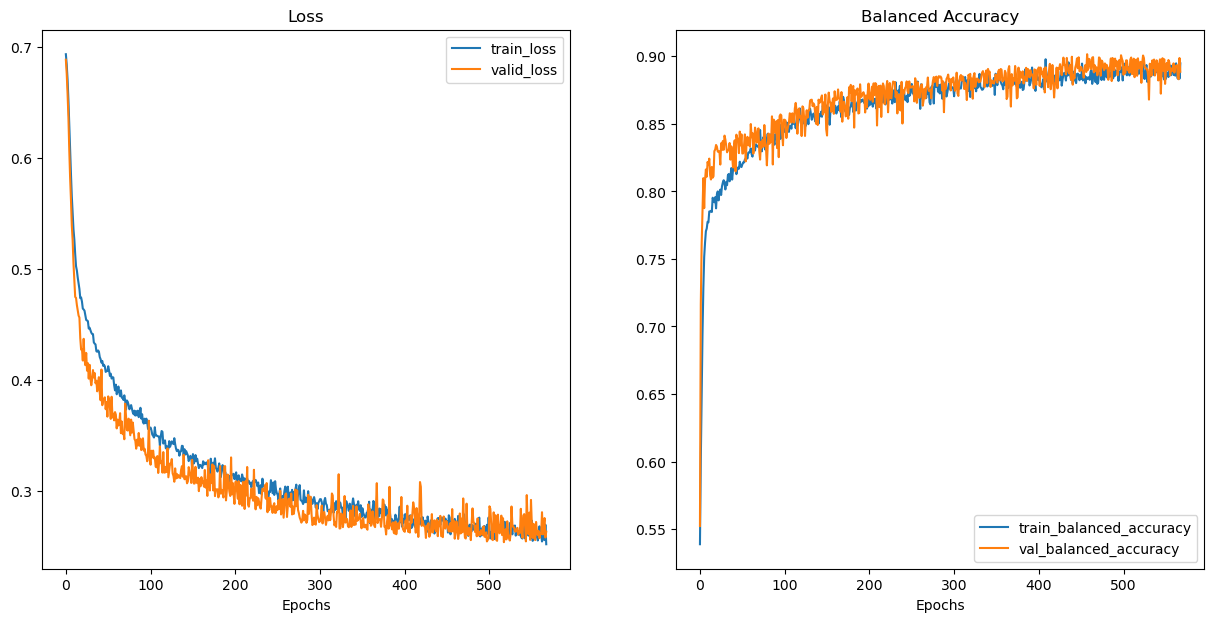

In [34]:
helper_functions.plot_loss_curves(results)
plt.savefig(f'All_TFs_CNN1_ADAM_BCEWithLogits_KERNEL=10_seq=200b.png')

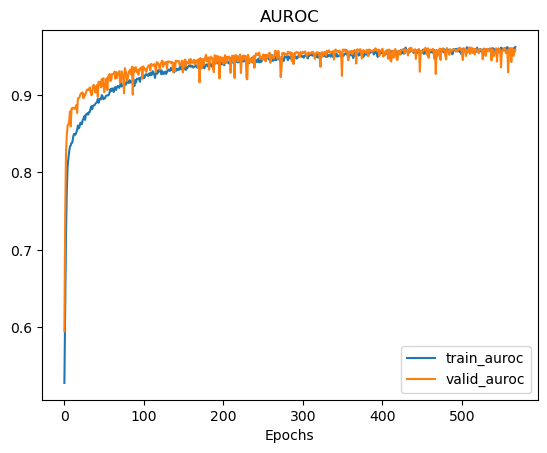

In [35]:
helper_functions.plot_auroc(results)

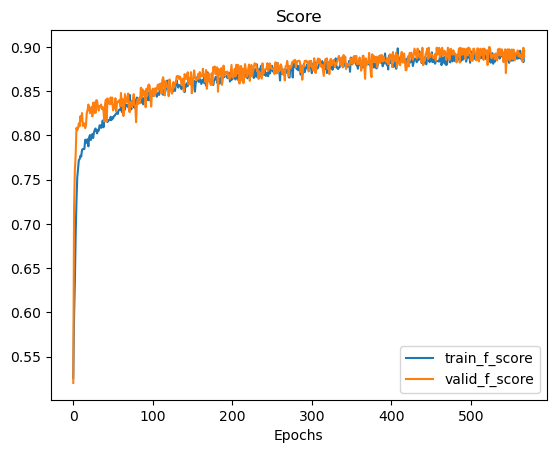

In [36]:
helper_functions.plot_f_score(results)

In [38]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
import torch.nn.functional as F


model.eval()


with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    all_test_pred_prob=[]
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y_one_hot, y) in enumerate(test_loader):
        # Send data to target device
        X, y_one_hot, y = X.to(device),y_one_hot.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y_one_hot)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_pred_prob = torch.softmax(test_pred_logits.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())
        all_test_pred_prob.extend(test_pred_prob.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print("Perfomance on held out test set")
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    

Perfomance on held out test set
Test loss: 0.4225641389687856 | Test bal acc 0.8231341120250328 | Test mcc 0.6504996062470955 | Test_f_score 0.8220150778575559

